## Imports

In [276]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F
from sklearn.metrics import f1_score
import seaborn as sns
from torch.autograd import Variable
plt.ion()   # interactive mode
%matplotlib inline
import tensorflow as tf
sns.set_style('darkgrid')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [277]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

In [278]:
#!unrar x '/content/drive/MyDrive/Image_Dataset1.rar'

## Reading Data

In [279]:
train = pd.read_csv('/content/drive/MyDrive/Attributes_final_.csv')
train.columns

Index(['image_id', 'count', 'Smiling', 'Wearing_Hat', 'Young', 'Eyeglasses',
       'Male', 'path'],
      dtype='object')

In [280]:
train["Smiling"].replace({-1: 0}, inplace=True)
train["Wearing_Hat"].replace({-1: 0}, inplace=True)
train["Young"].replace({-1: 0}, inplace=True)
train["Eyeglasses"].replace({-1: 0}, inplace=True)
train["Male"].replace({-1: 0}, inplace=True)
train['test']=1

In [281]:
train.head()

,image_id,count,Smiling,Wearing_Hat,Young,Eyeglasses,Male,path,test
0,000001.jpg,2880,1,0,1,0,0,2880/000001.jpg,1
1,000002.jpg,2937,1,0,1,0,0,2937/000002.jpg,1
2,000003.jpg,8692,0,0,1,0,1,8692/000003.jpg,1
3,000004.jpg,5805,0,0,1,0,0,5805/000004.jpg,1
4,000006.jpg,4153,0,0,1,0,0,4153/000006.jpg,1


In [282]:
y=train[['Smiling','Wearing_Hat','Young','Eyeglasses','Male']]

## Data Distribution

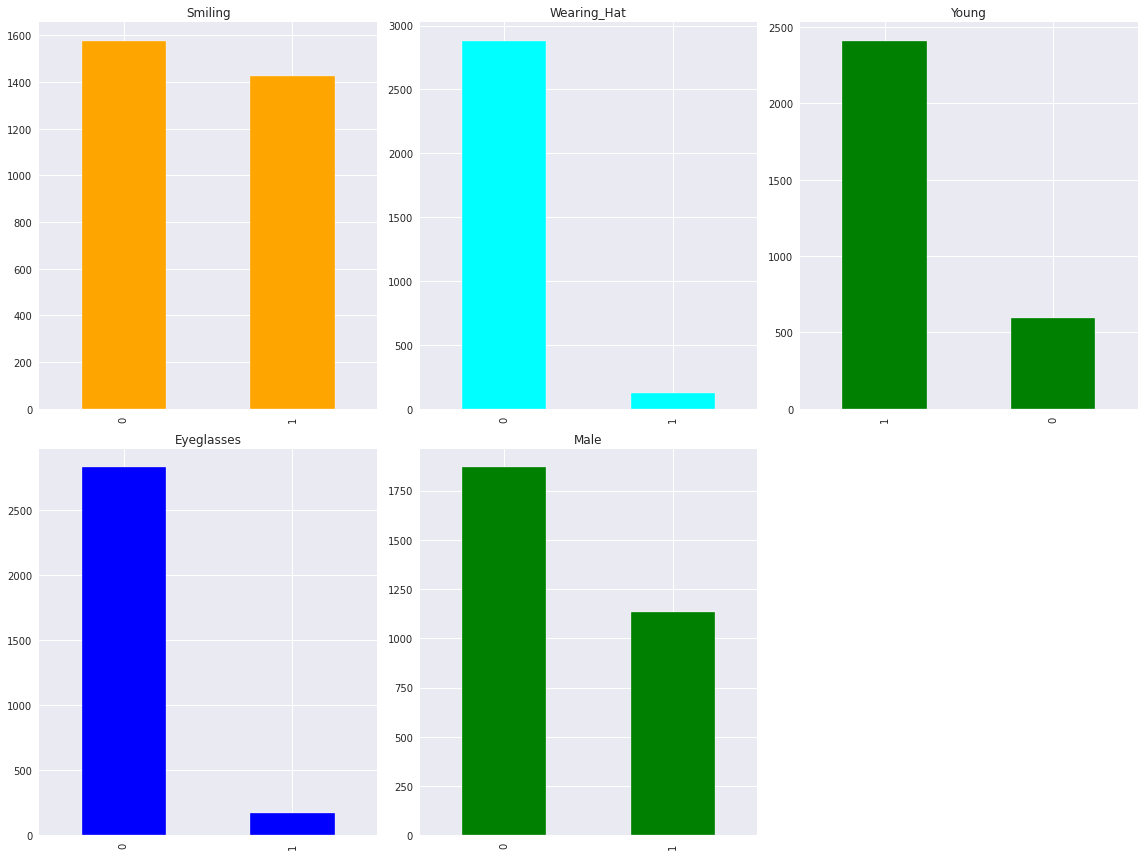

In [283]:
colors = ['orange', 'cyan', 'green','Blue','Green','yellow']
fig = plt.figure(1,figsize=(16,12))
for i, col in enumerate(y,1):
    fig.add_subplot(2,3,i,)
    y[col].value_counts().plot(kind='bar',ax=plt.gca(),color=colors[i-1])
    plt.title(col)
plt.tight_layout()
plt.show(1)

In [284]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
X=train['path']
y=train[['Smiling','Wearing_Hat','Young','Eyeglasses','Male']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True,random_state=42)
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()
#...........................................For Training................................
smile_train = y_train['Smiling']
smile_nodes=1
smile_train = smile_train.values.tolist()
gender_train = y_train['Male']
gender_nodes = gender_train.values.reshape(gender_train.shape[0],1)
gender_nodes=1
gender_train = gender_train.values.tolist()
Glasses_train = y_train['Eyeglasses']
Glasses_nodes = 1
Glasses_train = Glasses_train.values.tolist()
Young_train = y_train['Young']
Young_nodes = 1
Young_train = Young_train.values.tolist()
hat_train = y_train['Wearing_Hat']
hat_nodes = 1
hat_train = hat_train.values.tolist()

#............................................For testing....................................

smile_test = y_test['Smiling']
smile_nodes = 1
smile_test = smile_test.values.tolist()
gender_test = y_test['Male']
gender_nodes = 1
gender_test = gender_test.values.tolist()
Glasses_test = y_test['Eyeglasses']
Glasses_nodes = 1
Glasses_test = Glasses_test.values.tolist()
Young_test = y_test['Young']
Young_nodes = 1
Young_test = Young_test.values.tolist()
hat_test = y_test['Wearing_Hat']
hat_nodes = 1
hat_test = hat_test.values.tolist()


## Data Transformation

In [285]:
class ImageDataset(Dataset):
    def __init__(self,Data_list,path,transform=None):
        self.Data_list = Data_list
        self.transform = transform
        self.path=path     
    def __getitem__(self,index):        
        img1 = Image.open(path+self.Data_list[0][index])
        img1 = img1.convert('RGB')
        gender = self.Data_list[1][index] # gender
        Glasses = self.Data_list[2][index] # EyeGlasses
        Young = self.Data_list[3][index] # Young
        Hat = self.Data_list[4][index] # WearingHat
        Smile = self.Data_list[5][index] # Smiling
        if self.transform is not None:
            img1 = self.transform(img1)
        list_of_labels = [torch.from_numpy(np.array(gender)),
                      torch.from_numpy(np.array(Glasses)),
                      torch.from_numpy(np.array(Young)),
                      torch.from_numpy(np.array(Hat)),
                      torch.from_numpy(np.array(Smile))]
        return img1, list_of_labels[0],list_of_labels[1],list_of_labels[2],list_of_labels[3],list_of_labels[4]
    def __len__(self):
        return len(self.Data_list[0])

In [286]:
def Transformation(batch_size,path):
              data_transforms = {
                  'train': transforms.Compose([
                    transforms.Resize((64,64)),
                      transforms.ToTensor(),
                    transforms.Normalize([0.5109, 0.4284, 0.3849], [0.2695, 0.2484, 0.2435])
                  ]),
                  'val': transforms.Compose([
                      transforms.Resize((64,64)),
                      transforms.ToTensor(),
                   transforms.Normalize([0.5076, 0.4205, 0.3770], [0.2719, 0.2487, 0.2426])
                  ]),
              }
              train_lists = [X_train, gender_train,Glasses_train, Young_train, hat_train, smile_train]
              test_lists = [X_test, gender_test, Glasses_test,Young_test, hat_test,smile_test]

              training_dataset = ImageDataset(Data_list = train_lists,path=path, transform = data_transforms['train'] )

              test_dataset = ImageDataset(Data_list = test_lists,path=path,transform = data_transforms['val'] )

              dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                                'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                                }
              dataset_sizes = {'train':len(train_lists[0]),
                              'val':len(test_lists[0])}
              return dataloaders_dict,dataset_sizes


In [287]:
batch_size = 4
path='/content/Image_Dataset1/'
dataloaders_dict,dataset_sizes= Transformation(batch_size,path)
dataloaders_dict['train']

### Data Normalization

In [288]:
 def Normalization():       
        mean = 0.
        std = 0.
        for images, _,_,_,_,_ in dataloaders_dict['val']:
            batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)

        mean /= dataset_sizes['val']
        std /= dataset_sizes['val']
        return mean,std

In [289]:
mean,std=Normalization()
mean,std

(tensor([ 2.6273e-05,  9.6022e-05, -2.2010e-04]),
 tensor([0.9813, 0.9792, 0.9791]))

## Data Representation

In [290]:
batch = next(iter(dataloaders_dict['train']))
print(batch[0].shape)
print("Output label tensors: ", batch[1])
print("\nOutput label tensor shape: ", batch[1].shape)
simage = batch[0][0]
simage.shape


torch.Size([4, 3, 64, 64])
Output label tensors:  tensor([1, 0, 1, 1])

Output label tensor shape:  torch.Size([4])


torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


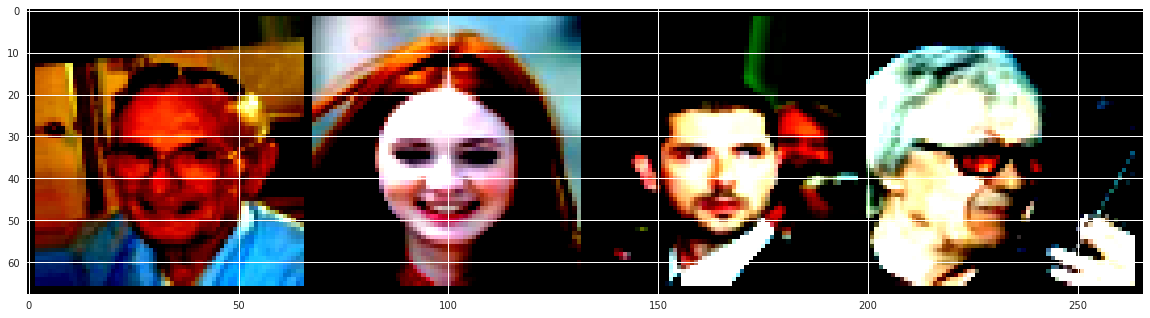

In [291]:
from torchvision import transforms, utils, datasets
batch_grid = utils.make_grid(batch[0], nrow=4)
plt.figure(figsize = (20,15))
plt.imshow(batch_grid.permute(1, 2, 0))

## Network

In [292]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
 def __init__(self,gender_nodes,Glasses_nodes,young_nodes,hat_nodes,smile_nodes):
      super(Net,self).__init__()
      self.conv1 = nn.Conv2d(3, 16, 5) 
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(16,32, 5, stride=2, padding=1)   
      self.fc1 = nn.Linear(1568,1024)  
      self.fc2 = nn.Linear(1024,512)  
      self.out=nn.Sigmoid()
      self.fc9 = nn.Linear(512,gender_nodes)
      self.fc10 = nn.Linear(512,Glasses_nodes)  
      self.fc11 = nn.Linear(512,young_nodes)  
      self.fc12= nn.Linear(512,hat_nodes)  
      self.fc13= nn.Linear(512,smile_nodes)  
 def forward(self, x):   
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x1 = self.fc9(x)
        xa=self.out(x1)
        x2 = self.fc10(x)
        xb=self.out(x2)
        x3 = self.fc11(x)
        xc=self.out(x3)
        x4 = self.fc12(x)
        xd=self.out(x4)
        x5 = self.fc13(x)
        xe=self.out(x5)
        return xa,xb,xc,xd,xe

In [293]:
model = Net(gender_nodes,Glasses_nodes,Young_nodes,hat_nodes,smile_nodes)
model.to(device)
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Sigmoid()
  (fc9): Linear(in_features=512, out_features=1, bias=True)
  (fc10): Linear(in_features=512, out_features=1, bias=True)
  (fc11): Linear(in_features=512, out_features=1, bias=True)
  (fc12): Linear(in_features=512, out_features=1, bias=True)
  (fc13): Linear(in_features=512, out_features=1, bias=True)
)


In [294]:
#hyper parameters
learning_rate = 0.001
# Model , Optimizer, Loss
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)
criterion = nn.BCELoss()

## Training Model

In [295]:
def binary_acc(y_pred, y_test):
    for i in range(len(y_pred)):
       if y_pred[i] > 0.5:
           y_pred[i]=1
       else:
           y_pred[i]=0
    acc = (y_pred == y_test).sum()
    return  acc

In [296]:
def predictions(y_pred):
    for i in range(len(y_pred)):
       if y_pred[i] > 0.5:
           y_pred[i]=1
       else:
           y_pred[i]=0
    return y_pred

In [297]:
def train_gender(net, training_data,validation_data,epochs,criterion,optimizer,validation):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loss=[]
    train_accuracy=[]
    gen_accuracy=[]
    eye_accuracy=[]
    young_accuracy=[]
    hat_accuracy=[]
    smile_accuracy=[]
    gen_vacc=[]
    eye_vacc=[]
    hat_vacc=[]
    young_vacc=[]
    smile_vacc=[]
    val_acc=[]
    t_loss=0
    val_loss=[]
    for epoch in range(epochs):
        loss_=0
        correct=0
        total=0
        acc1=0
        acc2=0
        acc3=0
        acc4=0
        acc5=0
        for batch, (data,gender,Glasses,young,hat,smile) in enumerate(training_data):
            data, gender,Glasses,young,hat,smile= Variable(data), Variable(gender),Variable(Glasses),Variable(young),Variable(hat),Variable(smile)
            data, gender,Glasses,young,hat,smile = data.to(device), gender.to(device),Glasses.to(device),young.to(device),hat.to(device),smile.to(device) 
            optimizer.zero_grad()
            pred_gender,pred_Glasses,pred_young,pred_hat,pred_smile = net(data)
            gender=gender.unsqueeze(1).float()
            Glasses=Glasses.unsqueeze(1).float()
            young=young.unsqueeze(1).float()
            hat=hat.unsqueeze(1).float()
            smile=smile.unsqueeze(1).float()
            loss1 = criterion(pred_gender,gender)
            loss2 = criterion(pred_Glasses,Glasses)
            loss3 = criterion(pred_young,young)
            loss4 = criterion(pred_hat,hat)
            loss5 = criterion(pred_smile,smile)
            t_loss=(loss1+loss2+loss3+loss4+loss5)/5
            t_loss.backward()
            optimizer.step()
            loss_+=t_loss.item()
            total += gender.size(0)
            acc1 += binary_acc(pred_gender,gender)
            acc2 += binary_acc(pred_Glasses,Glasses)
            acc3 += binary_acc(pred_young,young)
            acc4 += binary_acc(pred_hat,hat)
            acc5 += binary_acc(pred_smile,smile)
            correct=(acc1+acc2+acc3+acc4+acc5)/5
        train_loss.append(loss_/dataset_sizes['train'])
        train_accuracy.append(correct / float(total))
        gen_accuracy.append(acc1/ float(total))
        eye_accuracy.append(acc2/ float(total))
        young_accuracy.append(acc3 / float(total))
        hat_accuracy.append(acc4 / float(total))
        smile_accuracy.append(acc5 / float(total))
        print('Train Epoch: {} \tLoss: {}\tAccuracy: {}'.format( epoch,t_loss.item(),100*(correct / float(total))))
        print('.......................................')
        print('Gender Accuracy: {}\n EyeGlasses Accurcay: {}\n Young Accuracy: {}\n Hat Accurcay: {}\n Smile Accurcay: {}'.format(100*(acc1 / float(total)),100*(acc2 / float(total)),100*(acc3 / float(total)),100*(acc4 / float(total)),100*(acc5 / float(total))))
        print('\n')
        if validation==True:
          total_val=0
          correct_val=0
          v_loss=0
          accv1=0
          accv2=0
          accv3=0
          accv4=0
          accv5=0
          for batchv, (datav,genderv,Glassesv,youngv,hatv,smilev) in enumerate(validation_data, 0):
              datav, genderv,Glassesv,youngv,hatv,smilev= Variable(datav), Variable(genderv),Variable(Glassesv),Variable(youngv),Variable(hatv),Variable(smilev)
              datav, genderv,Glassesv,youngv,hatv,smilev = datav.to(device), genderv.to(device),Glassesv.to(device),youngv.to(device),hatv.to(device),smilev.to(device)       
              g_out,e_out,y_out,h_out,s_out= net(datav)
              genderv=genderv.unsqueeze(1).float()
              Glassesv=Glassesv.unsqueeze(1).float()
              youngv=youngv.unsqueeze(1).float()
              hatv=hatv.unsqueeze(1).float()
              smilev=smilev.unsqueeze(1).float()
              lossv1= criterion(g_out,genderv)
              lossv2 = criterion(e_out,Glassesv)
              lossv3 = criterion(y_out,youngv)
              lossv4= criterion(h_out,hatv)
              lossv5 = criterion(s_out,smilev)
              lossv=(lossv1+lossv2+lossv3+lossv4+lossv5)/5
              total_val += len(genderv)
              v_loss += lossv.item()
              accv1 += binary_acc(g_out,genderv)
              accv2 += binary_acc(e_out,Glassesv)
              accv3 += binary_acc(y_out,youngv)
              accv4 += binary_acc(h_out,hatv)
              accv5 += binary_acc(s_out,smilev)
              correct_val=(accv1+accv2+accv3+accv4+accv5)/5
          gen_vacc.append(accv1/ float(total_val))
          eye_vacc.append(accv2/ float(total_val))
          young_vacc.append(accv3 / float(total_val))
          hat_vacc.append(accv4 / float(total_val))
          smile_vacc.append(accv5 / float(total_val))
          val_loss.append(v_loss/dataset_sizes['val'])
          val_acc.append(correct_val / float(total_val))
          print('Validation Epoch: {} \tLoss: {}\tAccuracy: {}'.format( epoch,lossv.item(),100*(correct_val / float(total_val))))
          print('.......................................')
          print("Gender Accuracy: {} \nEyeGlasses Accurcay: {} \nYoung Accuracy: {} \nHat Accurcay: {} \nSmile Accurcay: {}".format(100*(accv1 / float(total_val)),100*(accv2 / float(total_val)),100*(accv3 / float(total_val)),100*(accv4 / float(total_val)),100*(accv5 / float(total_val))))
          print()
    return train_loss,train_accuracy,val_loss,val_acc,gen_vacc,eye_vacc,young_vacc,hat_vacc,smile_vacc,gen_accuracy,eye_accuracy,young_accuracy,hat_accuracy,smile_accuracy


In [298]:
train_loss,train_accuracy,val_loss,val_acc,gen_vacc,eye_vacc,young_vacc,hat_vacc,smile_vacc,gen_accuracy,eye_accuracy,young_accuracy,hat_accuracy,smile_accuracy=train_gender(model,dataloaders_dict['train'],dataloaders_dict['val'],14,criterion,optimizer,True)

Train Epoch: 0 	Loss: 0.4757609963417053	Accuracy: 76.30308532714844
.......................................
Gender Accuracy: 60.824310302734375
 EyeGlasses Accurcay: 93.71356964111328
 Young Accuracy: 79.72522735595703
 Hat Accurcay: 93.50540924072266
 Smile Accurcay: 53.74687957763672


Validation Epoch: 0 	Loss: 0.41657695174217224	Accuracy: 80.6655502319336
.......................................
Gender Accuracy: 69.21797180175781 
EyeGlasses Accurcay: 96.00665283203125 
Young Accuracy: 82.36273193359375 
Hat Accurcay: 96.33943176269531 
Smile Accurcay: 59.4010009765625

Train Epoch: 1 	Loss: 0.43698054552078247	Accuracy: 79.81681823730469
.......................................
Gender Accuracy: 69.90008544921875
 EyeGlasses Accurcay: 93.71356964111328
 Young Accuracy: 79.72522735595703
 Hat Accurcay: 95.83679962158203
 Smile Accurcay: 59.908409118652344


Validation Epoch: 1 	Loss: 0.13970841467380524	Accuracy: 81.66388702392578
.......................................
Gender Accur

## Saving Model

In [299]:
PATH = './task_CNNBestModel.pth'
torch.save(model.state_dict(), PATH)

## Loading Model

In [300]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Testing Model

In [301]:
test_loader=dataloaders_dict['val']

In [302]:
def test( model, test_data):
  total=0
  acc=0
  gen_pred = []
  gen_tar =  []
  eye_pred = []
  eye_tar =  []
  young_pred = []
  young_tar =  []
  hat_pred = []
  hat_tar =  []
  smile_pred = []
  smile_tar =  []
  acc1=0
  acc2=0
  acc3=0
  acc4=0
  acc5=0
  for data,gender,Glasses,young,hat,smile in test_data:
        genps,eyeps,yps,hps,sps= model(data)
        genps = genps.view(-1)
        eyeps = eyeps.view(-1)
        yps = yps.view(-1)
        hps = hps.view(-1)
        sps = sps.view(-1)
        gpred=predictions(genps)
        epred=predictions(eyeps)
        ypred=predictions(yps)
        hpred=predictions(hps)
        spred=predictions(sps)
        total += gender.size(0)
        acc1 += binary_acc(genps,gender)
        acc2 += binary_acc(eyeps,Glasses)
        acc3 += binary_acc(yps,young)
        acc4 += binary_acc(hps,hat)
        acc5 += binary_acc(sps,smile)
        acc=(acc1+acc2+acc3+acc4+acc5)/5
        gender=gender.detach().cpu().numpy()
        gpred=gpred.detach().cpu().numpy()
        Glasses=Glasses.detach().cpu().numpy()
        epred=epred.detach().cpu().numpy()
        young=young.detach().cpu().numpy()
        ypred=ypred.detach().cpu().numpy()
        hat=hat.detach().cpu().numpy()
        hpred=hpred.detach().cpu().numpy()
        smile=smile.detach().cpu().numpy()
        spred=spred.detach().cpu().numpy()
        gen_pred.append(gpred)
        gen_tar.append(gender)
        eye_pred.append(epred)
        eye_tar.append(Glasses)
        young_pred.append(ypred)
        young_tar.append(young)
        hat_pred.append(hpred)
        hat_tar.append(hat)
        smile_pred.append(spred)
        smile_tar.append(smile)
  print('Model Accuracy: {}%\n\n'.format(100 * (acc/total)))
  return gen_pred,gen_tar,eye_pred,eye_tar,young_pred,young_tar,hat_pred,hat_tar,smile_pred,smile_tar

In [303]:
 gen_pred,gen_tar,eye_pred,eye_tar,young_pred,young_tar,hat_pred,hat_tar,smile_pred,smile_tar=test(model,test_loader)

Model Accuracy: 91.2479248046875%




## Visualization

### Gender accuracy and Loss

In [304]:
def visualize_plots(epochs,train_loss,val_acc,train_acc,val_loss):
    epochs_= list(range(epochs))
    fig_size = (13, 11)
    fig, axes = plt.subplots(1, 2, figsize=fig_size)

    plt.style.use('seaborn')
    plt.subplot(221)
    plt.plot(epochs_,train_loss)
    plt.title("Epochs Vs Train Loss")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss per epoch")



    plt.subplot(222)
    plt.plot(epochs_,train_acc)
    plt.title("Epochs Vs Train Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Accuracy per epoch")

    plt.style.use('seaborn')
    plt.subplot(223)
    plt.plot(epochs_,val_loss)
    plt.title("Epochs Vs Validation Loss")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss per epoch ")



    plt.subplot(224)
    plt.plot(epochs_,val_acc)
    plt.title("Epochs Vs Validation Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Accuracy per epoch")


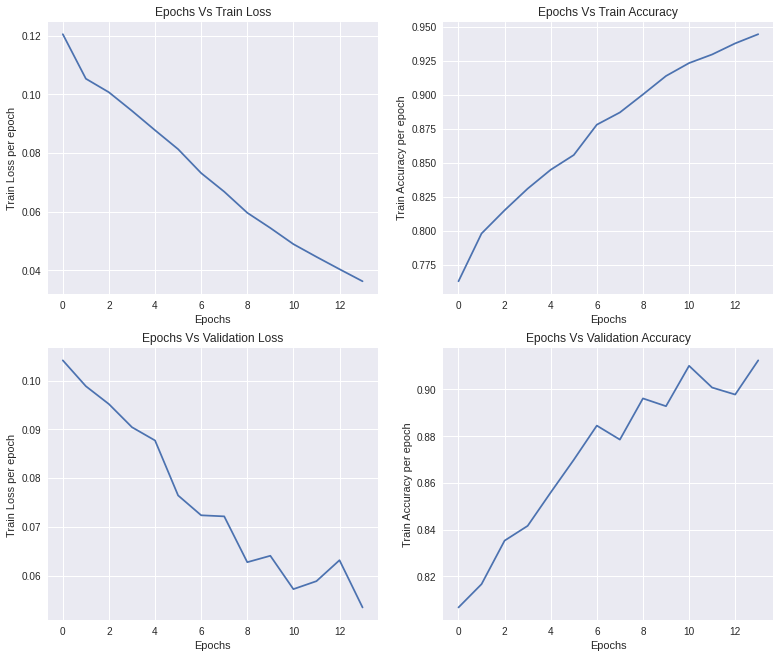

In [305]:
visualize_plots(14,train_loss,val_acc,train_accuracy,val_loss)

In [306]:
def visualize_plots_(epochs,val_acc,train_acc,str):
    epochs_= list(range(epochs))
    fig_size = (13, 11)
    fig, axes = plt.subplots(1, 2, figsize=fig_size)


    plt.subplot(221)
    plt.plot(epochs_,train_acc)
    plt.title("Epochs Vs Train Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Accuracy per epoch for "+str)


    plt.subplot(222)
    plt.plot(epochs_,val_acc)
    plt.title("Epochs Vs Validation Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Accuracy per epoch for "+str)


### Gender Training and Validation

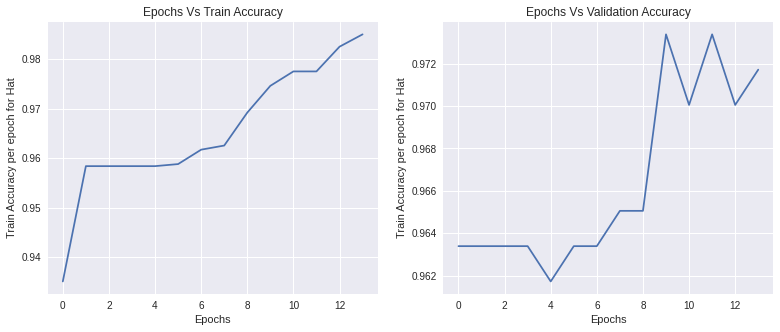

In [307]:
visualize_plots_(14,hat_vacc,hat_accuracy,'Hat')

In [308]:
from sklearn.metrics import confusion_matrix,classification_report
def confusion_matrix_plot(targets,predictions):
        pred= [item for sublist in  predictions for item in sublist]
        target_labels = [item for sublist in targets for item in sublist]
        cf_matrix = confusion_matrix(target_labels,pred)
        plt.figure(figsize = (15,10))
        sns.heatmap(cf_matrix, annot=True)


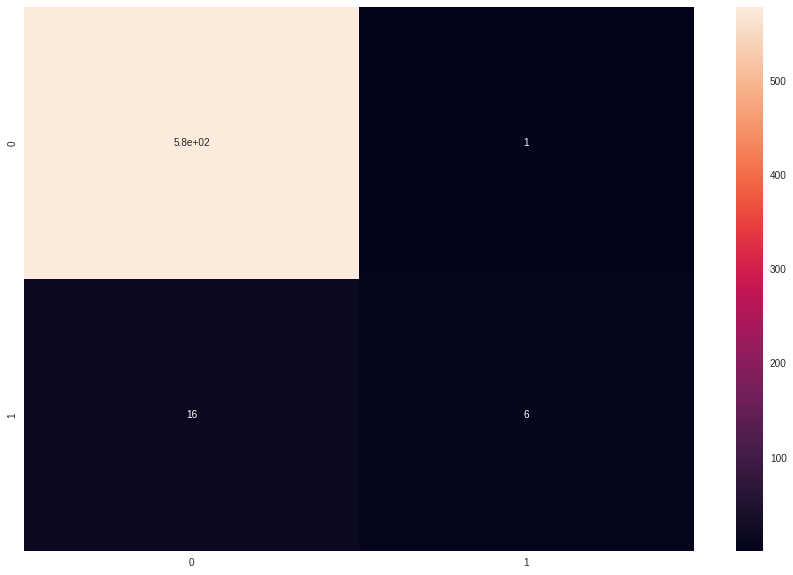

In [309]:
#gen_pred,gen_tar,eye_pred,eye_tar,young_pred,young_tar,hat_pred,hat_tar,smile_pred,smile_tar
confusion_matrix_plot(hat_tar,hat_pred)

## Predictions Results

In [310]:
from torch.autograd import Variable
def Labelextraction(label, pred,top=1):
      if(pred > 0.5):
          return label[1]
      else:
          return label[0]        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[Male,Not Wearing Glasses,Young,Not Wearing Hat,Smiling]



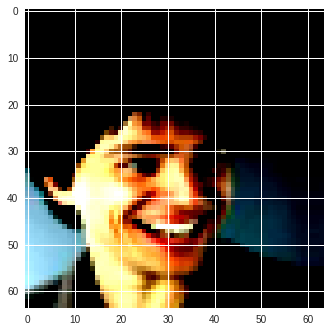

In [314]:
gender = ['Female','Male']
Glasses = ['Not Wearing Glasses','Wearing Glasses']
Young= ['Old','Young']
Wearing_hat = ['Not Wearing Hat','Wearing Hat']
Smile = ['Not Smiling','Smiling']
out = []
image,_,_,_,_,_=next(iter(test_loader))
img=image[0]
y1,y2,y3,y4,y5= model(img.view(1, img.shape[0],img.shape[1], img.shape[2]))
print()
s1=Labelextraction(gender,y1)
s2=Labelextraction(Glasses,y2)
s3=Labelextraction(Young,y3)
s4=Labelextraction(Wearing_hat,y4)
s5=Labelextraction(Smile,y5)
s='['+s1 + ',' + s2 +','+ s3 +','+ s4 +','+ s5 +']'
print(s)
print()
plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[Female,Not Wearing Glasses,Young,Not Wearing Hat,Smiling]



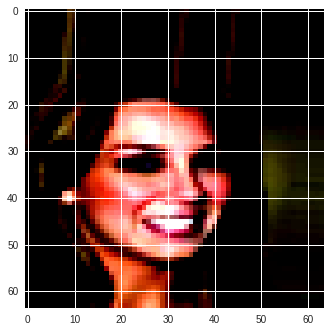

In [319]:
img=image[2]
y1,y2,y3,y4,y5= model(img.view(1, img.shape[0],img.shape[1], img.shape[2]))
print()
s1=Labelextraction(gender,y1)
s2=Labelextraction(Glasses,y2)
s3=Labelextraction(Young,y3)
s4=Labelextraction(Wearing_hat,y4)
s5=Labelextraction(Smile,y5)
s='['+s1 + ',' + s2 +','+ s3 +','+ s4 +','+ s5 +']'
print(s)
print()
plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[Female,Not Wearing Glasses,Young,Not Wearing Hat,Not Smiling]



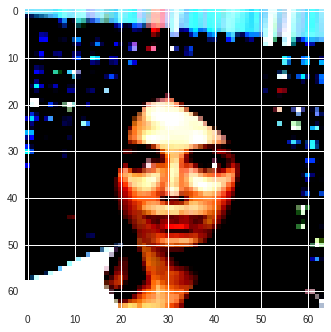

In [328]:
image,_,_,_,_,_=next(iter(test_loader))
img=image[1]
y1,y2,y3,y4,y5= model(img.view(1, img.shape[0],img.shape[1], img.shape[2]))
print()
s1=Labelextraction(gender,y1)
s2=Labelextraction(Glasses,y2)
s3=Labelextraction(Young,y3)
s4=Labelextraction(Wearing_hat,y4)
s5=Labelextraction(Smile,y5)
s='['+s1 + ',' + s2 +','+ s3 +','+ s4 +','+ s5 +']'
print(s)
print()
plt.imshow(img.permute(1, 2, 0))